In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs

# K-Means Clustering

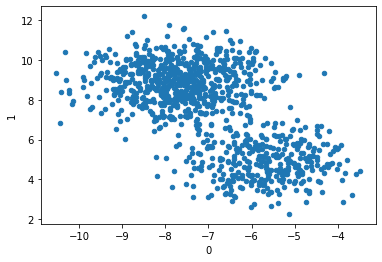

In [2]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2,)
X_df = pd.DataFrame(X)
X_df.plot.scatter(x=0, y=1)

In [3]:
class KMeans(): 
    def __init__(self, k=2): 
        self.k = k 
        self.centroids = {}
        self.label = []
        
        self._fitted = False 
    
    def fit(self, X):
        self._sse_tracker = []
        # Calculating the centroids
        if len(self.centroids.keys()) == 0:
            for k in range(self.k): 
                # Choose a random point between 
                # The min and max of each feature
                self.centroids[k] = np.random.uniform(
                    X.min(axis=0), 
                    X.max(axis=0)
                )
            print("Randomly Initialising the clusters")
                
        
        while True: 
            #1. Assign each point to its closest cluster
            all_distances = []
            for k in range(self.k):
                curr_centroid = self.centroids.get(k)
                curr_distances = self.distance(X, curr_centroid)
                all_distances.append(curr_distances)
                
            # Stacking them "columnwise"
            all_distances = np.hstack([arr.reshape(-1, 1) for arr in all_distances])
            
            # 1.1 indices (columnwise) of smallest distance
            #     Returns a 1D list with indices
            self.labels = np.argmin(all_distances, axis=1)
            
            # 2. Calculate the SSE 
            curr_sse = 0
            for k in range(self.k): 
                curr_assigned_points = X[self.labels == k]
                # SSE ~ "Sum of squared distances"
                curr_squared_dist = np.sum(
                    self.distance(curr_assigned_points, self.centroids.get(k))**2
                )
                curr_sse += curr_squared_dist
            
            self.sse = curr_sse
            self._sse_tracker.append(curr_sse)
            
            print("Current SSE: {}".format(curr_sse))
            
            # 3. We have now assigned each point to each closest cluster
            #    Now we have to recalculate the new centroids
            for k in range(self.k):
                X_clusters_mapped = X[self.labels == k]
                self.centroids[k] = X_clusters_mapped.mean(axis=0)
            
            
            # 4. Define crude stopping criteria
            #diff_to_next = lambda t: [j-i for i, j in zip(t[:-1], t[1:])]
            #diff_to_next_in_arr = diff_to_next(self._sse_tracker)
            
            if len(self._sse_tracker) > 1: 
                if self._sse_tracker[-1] == self._sse_tracker[-2]: 
                    print("Reached Stopping Criteria")
                    self._fitted = True 
                    return self
                if self._sse_tracker[-1] != self._sse_tracker[-1]: 
                    raise Exception("KMeans Creating NaN in SSE-Calculation got k = {}".format(self.k))
    
    
    
    def transform(self, X):
        """Calling transfrom returns cluster labels"""
        if not self._fitted: 
            raise Exception("Not yet fitted!")
        
        all_distances = []
        for k in range(self.k):
            curr_centroid = self.centroids.get(k)
            curr_distances = self.distance(X, curr_centroid)
            all_distances.append(curr_distances)
    
        # Stacking them "columnwise"
        all_distances = np.hstack([arr.reshape(-1, 1) for arr in all_distances])
        # Indices (columnwise) of smallest distance
        # Returns a 1D list with indices
        labels = np.argmin(all_distances, axis=1)
        return labels 
            
    
    def distance(self, X, centroid):
        # calculate the root of the sum of the squared distances
        return np.sqrt(np.sum((X - centroid)**2, axis=1))


## Try Out

In [4]:
kmeans = KMeans(k = 3) # Why k > 8 leads to NaN ? 
kmeans.fit(X)

Randomly Initialising the clusters
Current SSE: 4879.645369403555
Current SSE: 1576.395516642472
Current SSE: 1543.019936953957
Current SSE: 1537.0917439909242
Current SSE: 1532.7922929370027
Current SSE: 1527.359038262363
Current SSE: 1524.1726141137083
Current SSE: 1521.709892062169
Current SSE: 1519.0939610368582
Current SSE: 1517.7943440291265
Current SSE: 1516.675295627285
Current SSE: 1515.4320688723074
Current SSE: 1514.4133194741253
Current SSE: 1513.591310041215
Current SSE: 1513.4622632356932
Current SSE: 1513.4151505283871
Current SSE: 1513.4068493964
Current SSE: 1513.4068493964
Reached Stopping Criteria


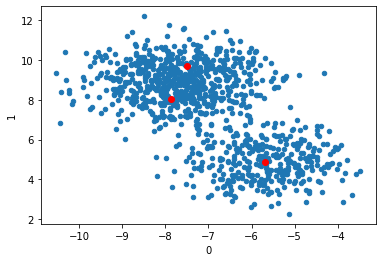

In [5]:
X_df = pd.DataFrame(X)
X_df.plot.scatter(x=0, y=1)
for k,v in kmeans.centroids.items(): 
    x,y = v.tolist()
    plt.plot(x,y,'ro')